# Computer Vision - Bilgisayarlı Görü

Merhabalar,

Bilgisayarlı Görü notebook'umuz içerisinde şunları inceleyeceğiz.
* Keras ile görüntü sınıflandırma yaparak , modern derin öğrenme ağlarını inceleyeceğiz.
* ResNet blokları ile kendi özel içeriğimizi hazırlayacağız.
* Görsellerden özellik çıkarımının arkasındaki temel fikre bakacağız.
* Modellerimizi daha verimli eğitmek için transfer öğrenmeye (transfer learning) bakacağız.
* Sınırlı veri kümelerinde çalışırken veri kümemizi artırmak için veri artırma (data augmentation)'yı inceleyeceğiz.
* Ve daha fazlası + detaylı açıklamalı kodlar 


Jupyter notebook'umuzu baştan sonra detaylıca incelediğinizde artık bilgisayar görüsü ile temel şeyler üzerinde bilgi sahibi olacaksınız. 

**1-) Giriş.**

Bİlgisayarlı Görü de amacımız, bir sinir ağının doğal bir görüntüyü nasıl anladığını öğrenmektir. Hedefimiz ise sinir ağına insanların görsel problemleri çözme yeteğini öğretmektir. Bu görevde en iyi olan sinir ağlarına convolutional neural networks ( CNN ya da convnet ) denir.

**2-) Convolutional Classifier.**

* Görüntü sınıflandırmada kullanılan bir CNN-Convnet iki bölümden oluşur. * convolutional base, * dense head
* Convolutional base: Görüntüden özellik çıkarımı için kullanılır.( renk , kenar, çizgi, desen , şekil vs )
* Dense head: Görüntünün sınıfını belirlemek için kullanılır. Yoğun katmanlardan meydana gelir.

Peki görseli sınıflandıran sınıflandırıcıyı nasıl eğitiriz ?

*Eğitim sırasında ağın amacı iki şeyi öğrenmektir:*

* Bir görüntüden hangi özelliklerin çıkarılacağı ( base )
* Hangi özelliklere sahip görüntüler, hangi sınıflara gider ( head )

CNN'ler nadiren de olsa sıfırdan eğitilir. Önceden eğitilmiş başarımı belli modelleri kullanmak daha mantıklıdır. Yani önceden eğitilmiş convolutional base' e eğitimsiz bir dense head takarız. Yani modelimizde özellik çıkarımı için daha önceden bir ağ yapısını kullanırken , sınıflandırma da bazı yeni katmanlarda ekleyerek istediğimiz şekilde kullanabiliriz. ( *transfer learning* )

**Uygulama**

İçerisinde kamyon ve araba resimleri olan veri setimiz ile CNN yapısını kurarak modele sonradan hiç görmediği bir resmi gösterdiğimizde kamyon ya da araba olarak sınıflandırmasını isteyeceğiz.
 

In [1]:
# Veri setimiz car-or-truck isminde içersinde eğitim ve doğrulama verileri bulunan veri setidir. Kaggle üzerinden indirilebilir.

# Veri setinin yüklenmesi.

# kütüphanelerin yüklenmesi.
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)


plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") 


# veri setinin yüklenmesi.
ds_train_ = image_dataset_from_directory(
    'car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)


def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [2]:
# önceden eğitilmiş base'ı tanımlıyoruz.
# ImageNet üzerine önceden eğitilmiş VGG16 modelini kullanacağız.

pretrained_base = tf.keras.models.load_model(
    'cv-course-models/vgg16-pretrained-base', compile=False
)
pretrained_base.trainable = False


In [3]:
# Şimdi ise sınıflandırıcımızı ayarlıyoruz(dense head)

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [4]:
# eğitim
# eğitim için epoch sayısını 30 belirledik. eğer yeterli donanım yok ise bu süre çok uzun olacaktır.
# epoch sayısını düşürebilirsiniz.

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=0,
)

In [ ]:
# sonuçların görselleştirilmesi.

import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

*Derin sinir ağlarının* geleneksel *makine öğrenme* modellerine göre sahip olduğu en büyük avantajlardan biri, doğru ağ yapısı göz önüne alındığında, derin sinir ağı problemini çözmek için ihtiyaç duyduğu özellikleri nasıl tasarlayacağını öğrenebilir. Ancak geleneksel makine öğrenmesinde bu işlem kişiler tarafından yapılır.


**3-) Convolution ve ReLU**

In [6]:
import numpy as np
from itertools import product

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

Bu ders grubunda ise CNN yapısının base kısmında bulunan özellik çıkarımı için çok önemli iki katman türü hakkında bilgi edineceğiz. Bunlardan birincisi *ReLU aktivasyon fonksiyonuna* sahip *Convolutional* katman diğeri ise maximum havuzlama *max pooling* katmanıdır.

* Özellik Çıkarma: Özellik çıkartma üç temel işlemden meydana gelir. Belirli bir özellik için bir görüntüyü 1-Filtrelere (konvolüsyon) , filtrelenmiş görüntüdeki bu özelliği algıla 2-ReLU, özellikleri geliştirmek için görüntüyü yoğunlaştırma. 3- Max Pooling
* Tipik olarak CNN ağı tek bir görüntü üzerinde paralel olarak bir kaç çıkarma işlemi gerçekleştirir. Modern CNN yapısında base de bulunan son katmanın 1000 den fazla benzersiz görsel özellik üretmesi bu şekilde açıklanır.

**Convolution'lu Filtreler**

In [8]:
# keras kullanarak convolution da filtre tanımı.

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), 
   
])

Bir CNN modelinin eğitim sırasında öğrendiği ağırlıklar öncelikle convolution katmanı ağırlıklarıdır. Bu ağırlıklara çekirdek ( **kernel** ) diyoruz. Kernel'ler küçük diziler olarak temsil edilir.

*Kernel* görüntüyü tarayarak ve ağırlıklı bir piksel değerleri toplamı üreterek çalışır. Yani şöyle diyelim. 3*3'lük bir kernel'imiz var elimizde. 9*9'luk piksellerden oluşan bir de görüntü. Kernel görüntünün üzerinde 3*3lük kısımlarda gezerek birebir ağırlık ve piksel çarpımı yapar. Bunu ise tek bir değer olarak döndürür. Yani kernel çıkıştaki tek noronü girişteki 9 norona bağlayacaktır. ( 3*3 'lük 2 matris var elimizde - kernel ve görüntütünün 3*3'luk kısmı ). Çekirdek boyutları kernel size ile ayarlanarak CNN yapısına bu bağlantının nasıl olacağı anlatılmış olur. Çoğu zaman çekirdek tek boyutlu sayılar ile temsil edilir.

Kernel'ler ne tür özellikler oluşacağını belirler. Eğitim esnasında bir CNN sınıflandırıcının ilgili problemini çözmek için hangi özelliklere ihtiyaç duyduğunu öğrenmeye çalışır.

**Activations**'lar kernel'in çıkardığı görsel özellikleri içerirler. Filtrelemeden sonra özellik haritaları etkinleştirme işlevinden geçer.**ReLU**

In [9]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu')
    # diğer convolution katmanları buraya eklenerek devam ederi
])

**Aktivasyon fonksiyonlarını** belirli bir önem ölçüsüne göre pixel değerlerini puanlama olarak düşünebiliriz. ReLU negetif değerleri önemli kabul etmez ve bunları 0 olarak ayarlar. ( Önemsiz olan herşey eşit derece de önemsizdir. )

**Uygulama**

Şimdi bir örnek üzerinde Convolution ve ReLU ya daha yakında bakalım. Filtreleme adımı için bir çekirdek tanımlayacağız. Ve sonrasında convolution'a uygulacağız. Bu çekirdek bir kenar algılama çekirdeği olacak. Bu tf ile tanımlayabiliriz. Sanki numpy da bir dizi tanımlıyor gibi tanımlama yapacağız. Bu bize tf'nin kullandığı türden bir tensör oluşturacaktır.

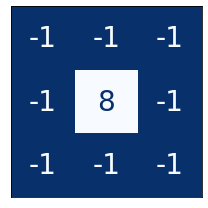

In [63]:
import tensorflow as tf

kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
])

plt.figure(figsize=(3, 3))
show_kernel(kernel)

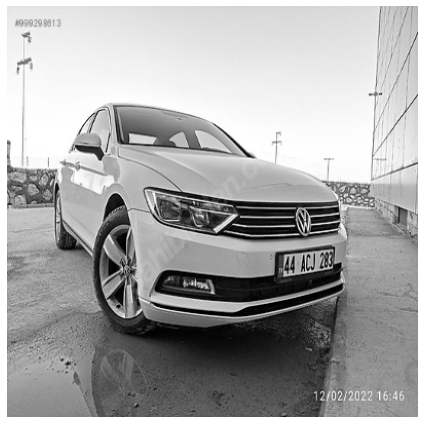

In [64]:
# test verimizi yükleyelim.

image_path = 'car-or-truck/test.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])

img = tf.squeeze(image).numpy()
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show();

Tensorflowda (tf) YSA için gerekli bir çok şey tf.nn içersinde bulunur. Biz örneğimizde 1 adet 2D conv2d ve bir adet de ReLU kullanacağız.

Aşağıda yazdığımız kod yaptığımız işlerimizi tf'ye uyumlu hale getirmek için yaptığımız bir dizi işlem. Bu ayrıntılar bu örneğimiz için pek de önemli değildir.

In [65]:
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

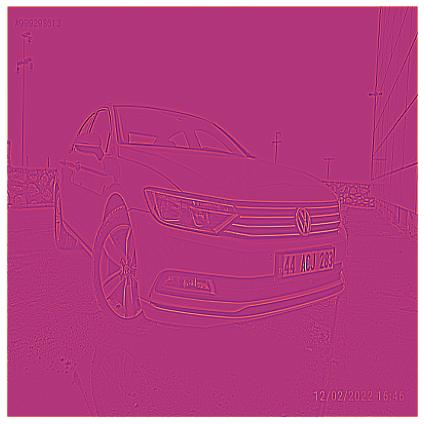

In [68]:
# verimize oluşturduğumuz kernel'ı filtre olarak uygulayalım.

image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.show();

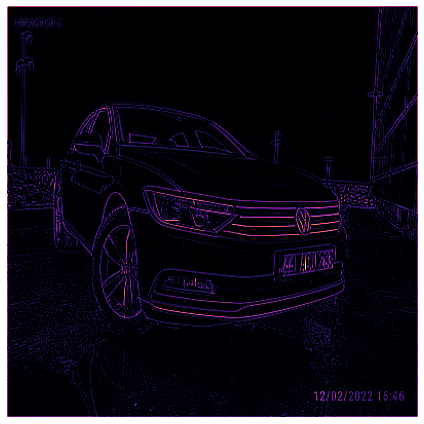

In [69]:
# bu ise direkt olarak nn modelü içerisinde gömülü olarak gelen kenar çıkarma kernel'i
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show();

**4-) Maximum Pooling**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), 
    layers.MaxPool2D(pool_size=2), # max pooling'in eklenmesi
    
])

Max Pooling katmanı kernel_size benzeri parametre olan pool_size ile kernel yerine basit bir max işlevi dışında Conv2D katmanına benzer. Bununla birlikte max pooling convolution katmanının yaptığı gibi eğitilebilir ağırlıklara sahip değildir. Max pooling yoğunlaştırma adımıdır.

* Resme ReLU ( algılama ) işlevini uyguladıktan sonra özellik haritasında çok fazla ölü alan yani değeri 0 olan ( resimdeki siyah alanlar ) alanların olduğuna dikkat edelim.
* Bu durum çok da önemli olmayan alanların modele verilmesine ve modelin daha fazla alan kaplamasına hem de yavaşlamasına neden olacaktır.
    * Bunun yerine özellik haritasını, özelliğin kendisini korunacak şekilde en kullanışlı kısımlarını alarak yoğunlaştırmak istiyoruz( Maximum Pooling)
* ReLU aktivasyonundan sonra uygulandığında yoğunlaştırıcı özelliklere sahiptir.
    

**Uygulama**

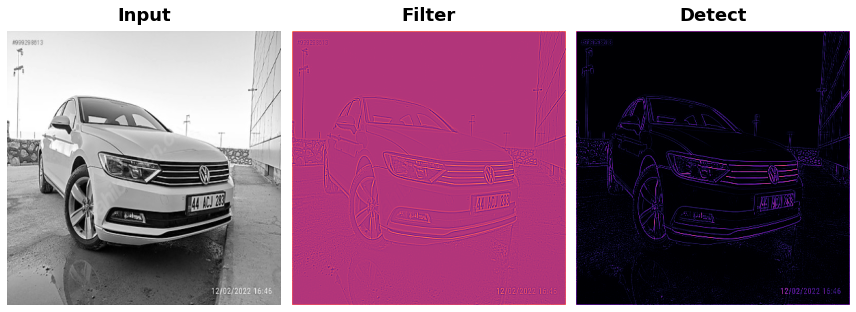

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") 

# resmin okunması.
image_path = 'car-or-truck/test.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])

# kernel'in tanımlanması ( köşe bulmak için tanımlanan kernel'dir.).
kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
], dtype=tf.float32)

# verinin tf ' ye uygun hale getirilmesi.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])

# filtre adımları
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='SAME'
)

image_detect = tf.nn.relu(image_filter)

# görüntüleme
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show();

Buraya kadar daha önceki yaptığımız örneğin aynısıydı. Şimdi tf de nn modülü içerindeki bir özelliği daha kullanacağız. " Max Pooling " "nn.pool"

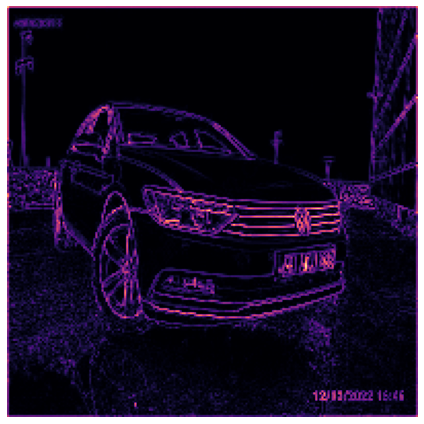

In [2]:
import tensorflow as tf

image_condense = tf.nn.pool(
    input=image_detect, # algılama adımındaki görüntü.
    window_shape=(2, 2),
    pooling_type='MAX',
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show();

işte iki resim arasındaki fark! Max pooling uygulanmadan önce ve uygulandıktan sonraki farklar gözle görülebilir.

0 pikselleri önemsiz olarak adlandırdır. Peki bu durum 0 piksellerin önemsiz oldukları anlamına mı geliyor. Tabi ki hayır. 0 pikselleri konumsal bilgi taşır. MaxPool sırasında sıfır pikselleri kaldırıldığında özellik haritasındaki bir takım konum bilgileri de kalkar. Bu bir CNN yapısına *Translation Invariance* adında bir özellik verir. Bu özellik maxpooling yapılacak olan bir cnn yapısına özellikleri görüntüdeki konumlarına göre ayırt etmeme eğilimde olacağı anlamına gelir. Bu durum bize ilerde veri zenginleştirme de ( Data Augmentation ) da işimize yarayacaktır.


**5-) The Sliding Window**

In [1]:
import numpy as np
from itertools import product
from skimage import draw, transform

def circle(size, val=None, r_shrink=0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius=size[0]//2 - r_shrink,
        shape=[size[0]+1, size[1]+1],
    )
    if val is None:
        circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
    else:
        circle[rr, cc] = val
    circle = transform.resize(circle, size, order=0)
    return circle

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

def show_extraction(image,
                    kernel,
                    conv_stride=1,
                    conv_padding='valid',
                    activation='relu',
                    pool_size=2,
                    pool_stride=2,
                    pool_padding='same',
                    figsize=(10, 10),
                    subplot_shape=(2, 2),
                    ops=['Input', 'Filter', 'Detect', 'Condense'],
                    gamma=1.0):
    # model katmanının oluşturulması
    model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(
                        filters=1,
                        kernel_size=kernel.shape,
                        strides=conv_stride,
                        padding=conv_padding,
                        use_bias=False,
                        input_shape=image.shape,
                    ),
                    tf.keras.layers.Activation(activation),
                    tf.keras.layers.MaxPool2D(
                        pool_size=pool_size,
                        strides=pool_stride,
                        padding=pool_padding,
                    ),
                   ])

    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
    layer_filter.set_weights([kernel])

    # Format for TF
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    # özelliklerin çıkarımı.
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
    
    # görselleştirme.
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)

Önceki derslerde bir resimden özellik çıkarım işlemini gerçekleştiren 3 özelliği detaylıca gördük.
* Konvolüsyon ile filtreler uyguladık.
* ReLU ile bu özellikleri algıladık.
* Max Pooling ile bu özellikleri yoğunlaştırdık.

Evrişim ve havuzlama işlemleri ortak bir özelliği taşır. Her ikisi de kayan pencereler üzerinde gerçekleşir. Konvolüsyonda bu pencere çekirdeğin boyutları ' kernel size ' parametresi ile verilir. Havuzlama da ise 'pool size ' olarak geçer.

* Hem konvolüsyon hem de havuzlama katmanını etkileyen iki parametre vardır. Bunlar pencerenin adımları ( strides ), ve görüntü kenarlarında dolgu kullanıp kullanılmayacağıdır. ( padding )
*Strides: Pencerenin her adımda ne kadar ilerleyeceğini belirler.
*Padding: Görüntünün kenarlarındaki pikselleri nasıl işlediğimiz açıklar.

In [3]:
# iki parametre ile ( padding ve strides ) konvolüsyon ve maxpooling tanımlanması:

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  activation='relu'),
    layers.MaxPool2D(pool_size=2,
                     strides=1,
                     padding='same')
    # daha fazla katman buraya eklenir.
])

**Stride**

Pencerenin her adımda hareket ettiği mesafesidir. Eğer adım fazla olacak şekilde artırılırsa resim üzerindeki değerli bilgiler gözden kaçabilir. Bununla birlikte maximum havuzlama katmanında (2,2) ya da (3,3) gibi 1'den büyük adım değerlerine sahip olacak ancak pencerenin kendinden daha büyük olmayacaktır.
    

**Padding**

Tensorflow üzerinde iki farklı parametre alabilir. padding = 'same' veya padding = 'valid.
* padding = 'valid' ayarladığımızda konvolüsyon penceresi tamamen girişin içinde kalacaktır. Dejavantaji çıktı küçülür. Yani piksel kaybedilir. Kernel'in boyutu artıkça padding='valid' durumunda çıktı daha da küçülür. Özellikle girişlerin boyutu küçük olduğunda ağın içereceği katman sayısını sınırlayacaktır.

* padding='same' ise girdinin boyutunu çıktının boyutuyla aynı hale getirmek için girdinin sınırlarını 0 ile doldurmaktır. valid üzerinde aldığımız sorunları bu şekilde aşabiliriz.VGG modeli padding için same kullanır. Ama çoğu modern CNN mimarileri ikisinin bir kombinasyonunu kullanacaktır.

**Uygulama**

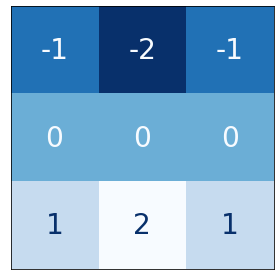

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image = circle([64, 64], val=1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])
# kernel tanımı
kernel = tf.constant(
    [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]],
)

show_kernel(kernel)

VGG mimarisi oldukça basittir. 1'lik adımlar ile konvolüsyon ve 2*2 lik pencereler ile 2 adım atacak şekilde max pooling kullanır. 

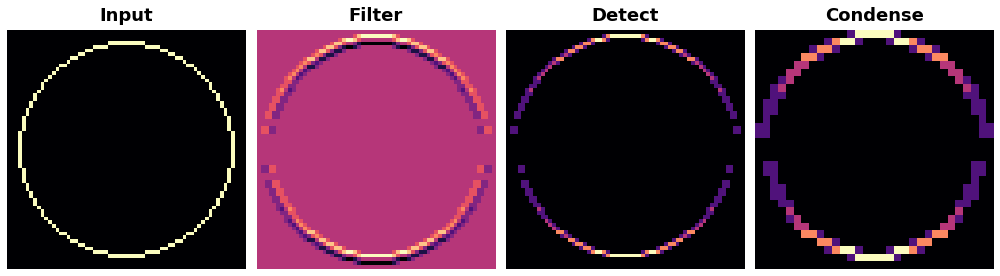

In [7]:
show_extraction(
    image, kernel,

    # pencere parametreleri ( vgg modelinden esinlendik :)
    conv_stride=1,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),
)

Yukarıdaki girdi ve çıktılara bir göz atalım. Kernel yatay çizgileri tespit etmek adına tanımlandı. Sonuçta ortaya çıkan özellik haritasında girdinin daha yatay kısımlarının en büyük aktivasyon ile sonuçlandığını görebiliyoruz.

Konvolüsyon adımlarını 3 olarak değiştirirsek ne olur ? --> Girdiden elde edeceğimiz çıkarımlar kötüleşir. Özellik kaybederiz.

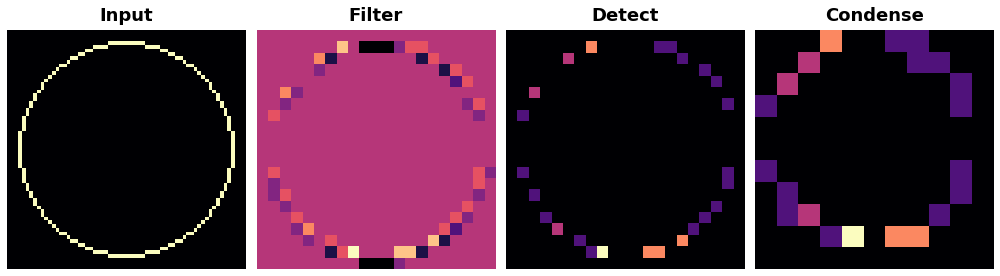

In [8]:
show_extraction(
    image, kernel,

    # pencere parametreleri.
    conv_stride=3, # konvolüsyonun adımlarını büyüttük.
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),    
)

Bazen modeller başlangıç katmanında daha büyük bir adım sayısı ile konvolüsyon kullanacaktır. Bu genellikle daha büyük de bir kernel ile de birleşecektir.( ResNet 50 modeli ). İlk katmanında 2 lik adımlar ile 7*7 kernel kullanır.Bu parametreler ne hikmetse girdiden çok fazla bilgi feda etmeden büyük ölçekli özelliklerin üretimini hızlandırıyor. 

**6-) Custom Convnets ( Özel CNN'ler)**

Artık bir CNN mimarisinin özellikleri ayıklamak için kullandığı katmanları biliyoruz. Artık bunların tamamını bir araya getirelim ve kendi CNN ağımızı oluşturalım.

CNN mimarisinin filtreleme , algılama ve yoğunlaştırma ile özellik çıkarımı hakkında bilgimiz var artık. Tek bir özellik çıkartma turu bir resimden basit çizgiler ve kontrastlar gibi nispeten basit özellikler çıkartalbilir. Bunun yerine CNN bu işlemi tekrar tekrar yaparak daha karmaşık özellikler üzerine inecektir.


*Convolutional Blocks* içerisinde Conv2D ve maxpooling barındıran uzun konvolisyon blok zincirleridir. Her blok içerisinde görüntü girdi olarak girer, conv, relu ve pooling işlemlerinden sonra çıktı olarak çıkar. Bir sonraki bloga bir önceki blogun çıktısı girdi olarak girer. Bu şekilde üretilen özellikler birleştirilir. Ve eldeki soruna daha iyi uyacak şekilde şekillendirilir. Modern CNN'lerin derin yapısı bu özellik mühendisliğine ( feature engineering ) izin veren ve üstün performans göstermelerine neden olan şeydir. ( geleceğin mesleklerinden :) )

**Uygulama**

Derin bir CNN ağı oluşturacağız. Keras kullanacağız ve Cars dataseti üzerinden eğitim yapacağız. Başlayalım!

In [9]:
# verinin yüklenmesi

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()


plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") 


# eğitim ve doğrulama verisetinin yüklenmesi.
ds_train_ = image_dataset_from_directory(
    'car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)


def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


**modelin tanımı:**
* 3 adet(blok) konvolüsyon ve maxpool kullanalım. kernel boyutumuz 3*3 lük olsun ve filtrelerimizi her layer da artıralım ( 32,64,128)
* konvolüsyon sonrasında verilerimizi tahmin için düzleştirelim( tek vektör haline ), 6 adet nöronu olan birinci katmana, sonrasında ise tahmini yapacağımız tek nöronlu son katmana gidelim.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    
    # birinci konvolüsyon blogumuz:
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same',
                  # ilk katman olduğu için girdi boyutlarını veriyoruz.
                  input_shape=[128, 128, 3]),  # [yükseklik, genişlik, RGB]
    layers.MaxPool2D(),

    # ikinci konvolüsyon blogumuz:
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # üçüncü konvolüsyon bloğumuz:
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # sınıflandırma (head)
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary() # modelimize bakalım.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)     

In [12]:
# eğitim

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=1,# bilgisayar donanımız iyiyse sayıyı artırın.
    verbose=0,
)

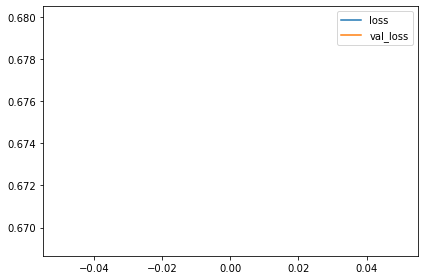

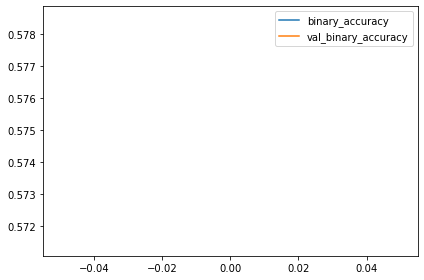

In [13]:
# görselleştirme 

import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

Bizim modelimiz birinci dersimizde kullandığımız VGG-16 modelinden çok küçüktür. VGG-16 daki 16 kıvrıma karşın bizde sadece 3 kıvrım mevcuttur. 

**7-) Data Augmentation**

Daha fazla veri demek modelin daha iyi çıkarımda bulunmasına yardımcı olabilir. Daha fazla veri almanın yolu zaten sahip olduğumuz verileri kullanmaktır. Veri kümemizdeki verileri sınıflarını koruyacak şekilde dönüştürebilirsek, sınıflandırıcımıza bu tür dönüşümleri görmezden gelmesi gerektiğini öğretebiliriz. Örneğin bir otomobilin resimde sağa ya da sola dönük olması bu örneğin otomobil örneği olduğu gerçeğini değiştirmez. Dolayısıyla eğitim verilerimizi bu tür veriler ile artırırsak , sınıflandırıcımız sol veya sağın göz ardı edilmesi gerektiği bilgisini öğrenebilir.
Kısaca gerçek verilere benzeyen bazı ekstra veriler eklediğimizde , sınıflandırıcımızın geliştiğini göreceksiniz.

Genellikle veri zenginleştirme işleminde görüntüyü döndürme , rengi ya da kontrastı ile oynama , görüntüyü deforme etme gibi bir çok yöntem kullanılır. 

Veri zenginleştirme genellikle veriler eğitim için ağı beslediğinde yapılır. Eğitim sırasında her görüntü kullanıldığında yeni bir rastgele dönüşüm uygulanır. Dolayısıyla modelimiz her zaman daha önce gördüğünden farklı birşeyler aramaya başlar.  

Keras verileri artırmak için iki farklı yöntem sunar. *İlk yol*, onu Image Data Generator gibi bir işlevle veri hattına dahil etmektir. *İkinci yol*, Keras'ın ön işleme katmanlarını kullanarak model tanımına dahil etmektir. Bizim için en büyük avantaj, görüntü dönüşümlerinin CPU yerine GPU üzerinde hesaplanması ve potansiyel olarak eğitimi hızlandırmasıdır.

**Uygulama**

In [14]:

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()


plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") 


# train ve test verisetimizin yüklenmesi
ds_train_ = image_dataset_from_directory(
    'car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [15]:
# modelin tanımlanması
# veri zenginleştirmenin etkisini görmek adına , dersin en başından beri kullandığımız model yapısına eklemede bulunacağız.

from tensorflow import keras
from tensorflow.keras import layers

# TF 2.2 ile gelen yeni özellik.
from tensorflow.keras.layers.experimental import preprocessing


pretrained_base = tf.keras.models.load_model(
    'cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

model = keras.Sequential([
    # veri ön işleme, (data augmentation)
    preprocessing.RandomFlip('horizontal'), # soldan sağa çevir.
    preprocessing.RandomContrast(0.5), # kontrastı %50 değiştir.
    # Base
    pretrained_base,
    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
# eğitim ve değerlendirme

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=3, # donanımınız yeterli ise sayıyı artırın.
    verbose=0,
)

In [ ]:
# görselleştirme

import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

Bir önceki eğitim sonuçlarına baktığımızda aradaki farkı görebiliyoruz. Data augmentation eğitimi büyük ölçüde olumlu yönde etkiliyor.